In [1]:

import Pkg
using JuMP
using HiGHS
using Ipopt
using Optimization
using Optim

model = Model(HiGHS.Optimizer)



A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [2]:
periods = 1:6

demand = Dict(
    1 => 180,
    2 => 250,
    3 => 190,
    4 => 140,
    5 => 220,
    6 => 250
)

prod_cost = Dict(
    1 => 50,
    2 => 45,
    3 => 55,
    4 => 52,
    5 => 48,
    6 => 50
)

hold_cost = Dict(
    1 => 8,
    2 => 10,
    3 => 10,
    4 => 10,
    5 => 8,
    6 => 8
)

capacity = 225


225

In [3]:
@variable(model, 0 <= x[i in periods] <= capacity)
@variable(model, I[i in periods] >= 0)

@constraint(model, x[1] - demand[1] == I[1])

@constraint(model, [i in 2:6], I[i-1] + x[i] - demand[i] == I[i])


1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 2:6
And data, a 5-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 x[2] + I[1] - I[2] == 250
 x[3] + I[2] - I[3] == 190
 x[4] + I[3] - I[4] == 140
 x[5] + I[4] - I[5] == 220
 x[6] + I[5] - I[6] == 250

In [4]:
@objective(model, Min, sum(prod_cost[i] * x[i] + hold_cost[i] * I[i] for i in periods))

optimize!(model)

println("Costo total mínimo: ", objective_value(model))
for i in periods
    println("Mes $i → Producir: ", value(x[i]), " unidades; Inventario final: ", value(I[i]))
end


Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 6 rows; 12 cols; 17 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [8e+00, 6e+01]
  Bound  [2e+02, 2e+02]
  RHS    [1e+02, 2e+02]
Presolving model
5 rows, 11 cols, 15 nonzeros  0s
3 rows, 8 cols, 10 nonzeros  0s
2 rows, 7 cols, 8 nonzeros  0s
Dependent equations search running on 2 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
2 rows, 7 cols, 8 nonzeros  0s
Presolve : Reductions: rows 2(-4); columns 7(-5); elements 8(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.6295000000e+04 Pr: 2(800) 0s
          3     6.1795000000e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 3
Objective value     :  6.1795000000e+04
P-D objective 

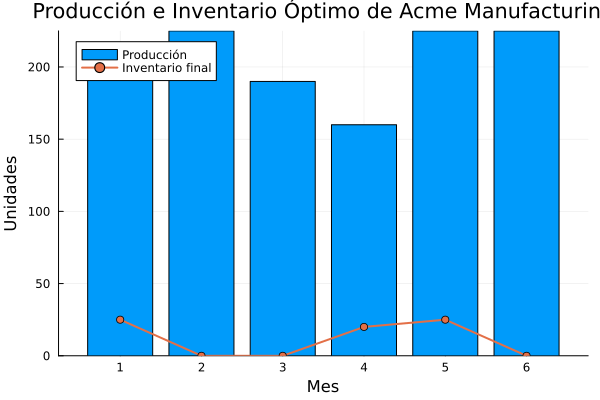

In [6]:
using Plots

prod_vals = [value(x[i]) for i in periods]
inv_vals  = [value(I[i]) for i in periods]

bar(periods, prod_vals, label="Producción", legend=:topleft)
plot!(periods, inv_vals, label="Inventario final", lw=2, marker=:circle)

xlabel!("Mes")
ylabel!("Unidades")
title!("Producción e Inventario Óptimo de Acme Manufacturing")


In [7]:
prod_naive    = [demand[i] for i in periods]
inv_naive     = zeros(length(periods))
cost_prod_naive  = [prod_cost[i] * prod_naive[i] for i in periods]
cost_inv_naive   = zeros(length(periods))
cost_total_naive = cost_prod_naive .+ cost_inv_naive

prod_opt    = [value(x[i]) for i in periods]
inv_opt     = [value(I[i]) for i in periods]
cost_prod_opt  = [prod_cost[i] * prod_opt[i] for i in periods]
cost_inv_opt   = [hold_cost[i] * inv_opt[i]  for i in periods]
cost_total_opt = cost_prod_opt .+ cost_inv_opt

savings = cost_total_naive .- cost_total_opt


6-element Vector{Float64}:
 -1450.0
  1125.0
     0.0
 -1240.0
  -440.0
  1250.0

In [11]:
using DataFrames

df = DataFrame(
    Mes               = periods,
    Prod_Opt          = prod_opt,
    Inv_Opt           = inv_opt,
    Costo_Prod_Opt    = cost_prod_opt,
    Costo_Inv_Opt     = cost_inv_opt,
    Costo_Total_Opt   = cost_total_opt,
    Prod_Naive        = prod_naive,
    Inv_Naive         = inv_naive,
    Costo_Prod_Naive  = cost_prod_naive,
    Costo_Inv_Naive   = cost_inv_naive,
    Costo_Total_Naive = cost_total_naive,
    Ahorro            = savings
)

println(df)


6×12 DataFrame
 Row │ Mes    Prod_Opt  Inv_Opt  Costo_Prod_Opt  Costo_Inv_Opt  Costo_Total_Opt  Prod_Naive  Inv_Naive  Costo_Prod_Naive  Costo_Inv_Naive  Costo_Total_Naive  Ahorro  
     │ Int64  Float64   Float64  Float64         Float64        Float64          Int64       Float64    Int64             Float64          Float64            Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1     205.0     25.0         10250.0          200.0          10450.0         180        0.0              9000              0.0             9000.0  -1450.0
   2 │     2     225.0      0.0         10125.0            0.0          10125.0         250        0.0             11250              0.0            11250.0   1125.0
   3 │     3     190.0      0.0         10450.0            0.0          10450.0         190        0.0             10450              0.0            104

Al comparar con la “solución” de producir exactamente la demanda de cada mes (sin atender la restricción de capacidad), vemos que en los meses 2 y 6 el modelo óptimo logra ahorros importantes (1 125 y 1 250 Q) al anticipar producción cuando el costo unitario es bajo y luego cubrir demanda con inventario, mientras que en el mes 3 el costo resulta idéntico. Sin embargo, en los meses 1, 4 y 5 el costo de almacenamiento (200 Q en cada uno) supera la ventaja de producir anticipadamente, generando ahorros negativos (–1 450 Q, –1 240 Q y –440 Q, respectivamente). En total el ahorro neto acumulado es –755 Q, lo que indica que, si ignorásemos la capacidad, el esquema de inventarios en este caso resulta más caro que producir exactamente a demanda. 

In [12]:

model_int = Model(HiGHS.Optimizer)

@variable(model_int, 0 <= x_int[i in periods] <= capacity, Int)
@variable(model_int, I_int[i in periods] >= 0)

@constraint(model_int, x_int[1] - demand[1] == I_int[1])
@constraint(model_int, [i in 2:6], I_int[i-1] + x_int[i] - demand[i] == I_int[i])

@objective(model_int, Min, sum(prod_cost[i]*x_int[i] + hold_cost[i]*I_int[i] for i in periods))

optimize!(model_int)


Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 6 rows; 12 cols; 17 nonzeros; 6 integer variables (0 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [8e+00, 6e+01]
  Bound  [2e+02, 2e+02]
  RHS    [1e+02, 2e+02]
Presolving model
5 rows, 11 cols, 15 nonzeros  0s
3 rows, 9 cols, 11 nonzeros  0s
2 rows, 7 cols, 8 nonzeros  0s
2 rows, 5 cols, 6 nonzeros  0s
2 rows, 5 cols, 6 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   2 rows
   5 cols (0 binary, 3 integer, 2 implied int., 0 continuous, 0 domain fixed)
   6 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes   

In [16]:
using Printf
obj_cont = objective_value(model)

obj_int  = objective_value(model_int)

println("Costo continuo = ", obj_cont)
println("Costo entero   = ", obj_int, "\n")

println("Mes | x_cont ↔ x_int  | I_cont ↔ I_int")
for i in periods
    @printf("%3d | %7.1f ↔ %4d | %7.1f ↔ %7.1f\n",
        i,
        value(x[i]), Int(round(value(x_int[i]))),
        value(I[i]), value(I_int[i])
    )
end

println("\n¿Misma solución óptima? ", obj_cont == obj_int ? "Sí" : "No")


Costo continuo = 61795.0
Costo entero   = 61795.0

Mes | x_cont ↔ x_int  | I_cont ↔ I_int
  1 |   205.0 ↔  205 |    25.0 ↔    25.0
  2 |   225.0 ↔  225 |     0.0 ↔     0.0
  3 |   190.0 ↔  190 |     0.0 ↔    -0.0
  4 |   160.0 ↔  160 |    20.0 ↔    20.0
  5 |   225.0 ↔  225 |    25.0 ↔    25.0
  6 |   225.0 ↔  225 |     0.0 ↔    -0.0

¿Misma solución óptima? Sí
